## Cart and Pole problem

Installation
To get started, you'll need to have Python 3.5+ installed. Simply install gym using pip:

In [1]:
#pip install gym

And you're good to go!

Building from source
If you prefer, you can also clone the gym Git repository directly. This is particularly useful when you're working on modifying Gym itself or adding environments. Download and install using

git clone https://github.com/openai/gym
cd gym
pip install -e

# Install PyTorch

In [2]:
#conda install pytorch-cpu torchvision-cpu -c pytorch

In [3]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for i in range(100):
    env.render()
    env.step(env.action_space.sample())
    print(f"This is {i} iteration.")
env.close()

This is 0 iteration.
This is 1 iteration.
This is 2 iteration.
This is 3 iteration.
This is 4 iteration.
This is 5 iteration.
This is 6 iteration.
This is 7 iteration.
This is 8 iteration.
This is 9 iteration.
This is 10 iteration.
This is 11 iteration.
This is 12 iteration.


/home/ssdl/anaconda3.1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


This is 13 iteration.
This is 14 iteration.
This is 15 iteration.
This is 16 iteration.
This is 17 iteration.
This is 18 iteration.
This is 19 iteration.
This is 20 iteration.
This is 21 iteration.
This is 22 iteration.
This is 23 iteration.
This is 24 iteration.
This is 25 iteration.
This is 26 iteration.
This is 27 iteration.
This is 28 iteration.
This is 29 iteration.
This is 30 iteration.
This is 31 iteration.
This is 32 iteration.
This is 33 iteration.
This is 34 iteration.
This is 35 iteration.
This is 36 iteration.
This is 37 iteration.
This is 38 iteration.
This is 39 iteration.
This is 40 iteration.
This is 41 iteration.
This is 42 iteration.
This is 43 iteration.
This is 44 iteration.
This is 45 iteration.
This is 46 iteration.
This is 47 iteration.
This is 48 iteration.
This is 49 iteration.
This is 50 iteration.
This is 51 iteration.
This is 52 iteration.
This is 53 iteration.
This is 54 iteration.
This is 55 iteration.
This is 56 iteration.
This is 57 iteration.
This is 58

No optimization and no instruction for when to end an episode

## STEPS for running Reinforcement Learning Projects
1. Initialize replay memory capacity.
2. Initialize the policy network with random weights.
3. Clone the policy network, and call it the target network.
4. For each episode:
    1. Initialize the starting state.
    2. For each time step:
        1. Select and action.
            - Via exploration or exploitation
        2. Execute selected action in an emulator
        3. Observe reward and next state.
        4. Store experience in replay memory.
        5. Sample random batch from replay memory.
        6. Preprocess states from batch.
        7. Pass batch of preprocessed states to policy network.
        8. Calculate loss between output Q-values and target Q-values:
            - Requires a pass to the target network for the next state
        9. Gradient descent updates weights in the policy network to minimize loss:
            - After x time steps, weights in the target network are updated to the weights in the policy network.

## Import Libraries

In [4]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Set up display

In [5]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython : from IPython import display

## Deep Q-Network

In [6]:
class DQN(nn.Module):
    '''
    To build a neural network with Pi Torch, we use the torch.nn package which we have given alias as nn (when importing)
    torch.nn package contains all the typical components needed to build neural networkd.
    Within the nn package, there's a class called 'module', Module is the base class for all neural network modules
    and so our netword and all of its layers will extend the nn.module.
    
    Our DQN will receive screenshot like images of the cart and pull environment as input, so to create DQN object
    will require the height and width of the image that will be passed to the model.
    '''
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features = 24, out_features = 32)
        self.out = nn.Linear(in_features = 32, out_features =2)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Experience class

In [7]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

In [8]:
e = Experience(2, 3, 1, 4)

In [9]:
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay Memory

In [10]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0 # Create push_count attribute and initialize to 0, this is used to keep track of how many experiences we've added to memory
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
            
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy

In [11]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

## Reinforcement Learning Agent

In [12]:
class Agent():
    def __init__(self, strategy, num_actions, device): # num_actions = how many possible actions that agent can take from a given state
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        self.current_step = 0
        
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions) # This was the mistake
            return torch.tensor([action]).to(device) #explore
        else:
            with torch.no_grad(): # Turn off gradient tracking since we're currently using the model just for inference and not training
                return policy_net(state).argmax(dim=1).to(device) # exploit #initially it was .item()

## Environment Manager

In [13]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close (self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item()) # env.step(env.action_space.sample())
       # _, reward, self.done, _ = self.env.step(action) #self.done
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height (self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width (self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen (self):
        screen = self.render('rgb_array').transpose((2, 0 , 1)) # PyTorch DQN expects
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen (self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen [:, top:bottom, :]
        return screen
    
    def transform_screen_data (self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([T.ToPILImage(), T.Resize((40, 90)), T.ToTensor()]) #steps to execute(1, 2, 3, ...)
        return resize(screen).unsqueeze(0).to(self.device) # Add a batch dimension since the processed images will be passed to DQN
    

## Example of non-processed screen

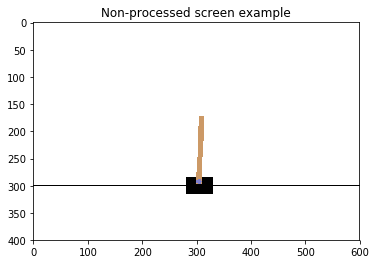

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show(block=False)
plt.pause(3)
plt.close()
#em.close()

## Example of processed screen

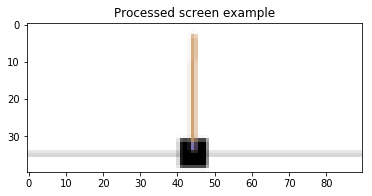

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()

screen = em.get_processed_screen()


plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()
plt.pause(3)
plt.close()
#em.close()

## Example of starting state

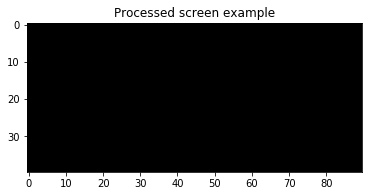

In [16]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()
plt.pause(3)
plt.close()

## Example of non-starting state

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


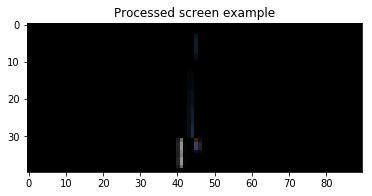

In [17]:
for i in range(5):
    em.take_action(torch.tensor([1]))
    
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()
plt.close()

## Exmaple of end state

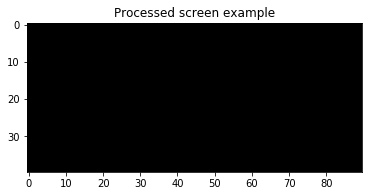

In [18]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()
#em.close()
plt.close()

## Utility functions

### Plotting

In [19]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    #print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    
    
    if is_ipython:
        display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
        
        


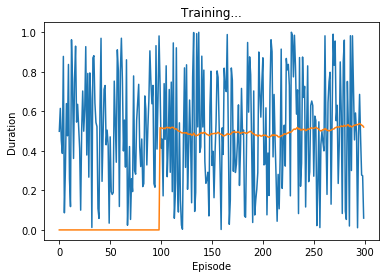

In [20]:
plot(np.random.rand(300), 100)

In [21]:
def extract_tensors(experiences):
    '''Accepts a batch of experiences and first transposes it into an experience of batches.'''
    
    batch = Experience(*zip(*experiences)) # Call the result of this operation as in the demonstration below
    
    t1 = torch.cat(batch.state) # Calling torch.cat(), we extract all the states from this batch into their own state tensor
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4) # Retun tuple that caontains the state, action, reward, next_state tensors

### Example of Experience(*zip(*experiences)) used above
see https://stackoverflow.com/a/19343/3343043

In [22]:
'''
Example to understand the extract_tensors() function
1. Create three sample experiences
2. Put them in the list
'''

e1 = Experience(1, 1, 1, 1) #First experience has state, action, next_stage_reward all equal to 1
e2 = Experience(2, 2, 2, 2)
e3 = Experience(3, 3, 3, 3,)

experiences = [e1, e2, e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [23]:
# Let's execute the same line from our function that we're trying to understand
# If we execute the following lines and print it out, we can see that we do now indeed have this experience object
# where the state attribute is set to the tuple containing all the states from e1, e2 and e3 in the original
# experiences list. Similarly the action, next_state and reward attributes contain tuples which contain all the
# corresponding values from the experience list. So now that we see what this line does, let's go back to
# extract tensors to see what happens next.

batch = Experience(*zip (*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

## Q-Value Calculator

# Main Program

In [24]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

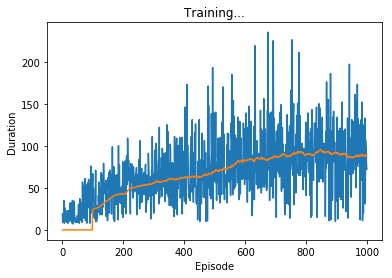

In [25]:
 ### HYPERPARAMETERS ### 
    # To show line number Ctrl + Shift + P and searc for "line Number"
batch_size = 256
gamma = 0.999
eps_start = 1 #starting value of epsilon (epsilon is the name of exploration rate)
eps_end = 0.01 # Ending value of epsilon
eps_decay = 0.001 # Decay rate of epsilon overtime
target_update = 10 # this is how frequent (in terms of episodes) will update the target nerwork's weight with the policy network's weight
memory_size = 100000 # Capacity of rely memory 
lr = 0.001 # Learning rate  
num_episodes = 1000


### ESSENTIAL OBJECTS USING THE CLASSES BUILT PREVIOUSLY ###

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)


### DEFINE POLICY NETWORK AND TARGET NETWORK ### Line 20
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device) # DQN(img_height, img_width)
#print(f"this is policy_net {policy_net}")

# =========OUTPUT=============
'''is is policy_net DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)'''
#============= END========================= Line30
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

### START TRAINING ###

episode_durations = []
for episode in range (num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action) # CHANGES MADE
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            #print(f"List of experiences {experiences}")
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss= F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad() # This function creates the graduents of all the weight and biases in the policy net to 0
            loss.backward() # 0 shoudl be called before backpropagation occurs
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100) # 100 is moving average
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()